In [1]:
import torch
from lavis.models import load_model_and_preprocess
import pandas as pd
import os
from PIL import Image
import logging
import argparse
from torch.utils.data import Dataset
from tqdm import tqdm
import torch.utils.data as data

/homes/yg007/nytimes_project/venv_nyc/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from lavis.models import model_zoo
print(model_zoo)

Architectures                  Types
albef_classification           ve
albef_feature_extractor        base
albef_nlvr                     nlvr
albef_pretrain                 base
albef_retrieval                coco, flickr
albef_vqa                      vqav2
alpro_qa                       msrvtt, msvd
alpro_retrieval                msrvtt, didemo
blip_caption                   base_coco, large_coco
blip_classification            base
blip_feature_extractor         base
blip_image_text_matching       base, large
blip_nlvr                      nlvr
blip_pretrain                  base
blip_retrieval                 coco, flickr
blip_vqa                       vqav2, okvqa, aokvqa
blip2_opt                      pretrain_opt2.7b, pretrain_opt6.7b, caption_coco_opt2.7b, caption_coco_opt6.7b
blip2_t5                       pretrain_flant5xl, pretrain_flant5xl_vitL, pretrain_flant5xxl, caption_coco_flant5xl
blip2_feature_extractor        pretrain, pretrain_vitL, coco
blip2                      

In [3]:
# Logger
logger = logging.getLogger()
logging.basicConfig(
    level=os.environ.get("LOGLEVEL", "INFO"),
    format="[%(asctime)s]:[%(processName)-11s]" + "[%(levelname)-s]:[%(name)s] %(message)s",
)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# blip2 captioning
model, vis_processors, _ = load_model_and_preprocess(name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device)

Position interpolate from 16x16 to 26x26


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.72s/it]
[2023-11-07 06:47:58,943]:[MainProcess][INFO]:[timm.models.hub] Downloading: "https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/BLIP2/blip2_caption_flant5xl.pth" to /homes/yg007/.cache/torch/hub/checkpoints/blip2_caption_flant5xl.pth

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.07G/4.07G [02:23<00:00, 30.5MB/s]
[2023-11-07 06:50:28,517]:[MainProcess][INFO]:[root] Missing keys ['t5_model.shared.weight', 't5_model.encoder.embed_tokens.weight', 't5_model.encoder.block.0.layer.0.SelfAttention.q.weight', 't5_model.encoder.block.0.layer.0.SelfAttention.k.weight', 't5_model.encoder.block.0.layer.0.SelfAttention.v.weight', 't5_model.encoder.block.0.layer.0.SelfAttention.o.weight', 't5_model.encoder.block.0.layer.0.SelfAttention.relative_

[2023-11-07 06:50:28,518]:[MainProcess][INFO]:[root] load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/BLIP2/blip2_caption_flant5xl.pth


In [4]:
# blip captioning
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device)

[2023-11-06 08:03:18,641]:[MainProcess][INFO]:[root] Missing keys []
[2023-11-06 08:03:18,645]:[MainProcess][INFO]:[root] load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/BLIP/blip_coco_caption_base.pth


In [6]:
val_feather_path = '../raw_data/val_completed_exist.feather'
val_df = pd.read_feather(val_feather_path)  # already drop the non-exists
val_img_dir = '/import/network-temp/yimengg/data/twitter-comms/images/val_images/val_tweet_image_ids'

Generated caption:
['a fighter jet sits on top of a runway with fog in the background']
Original text:
The Rafale fighter jet would be taking part in the Air Force Day parade for the first time on October 8. The combat aircraft was officially inducted into the Indian Air Force on September 10 in #Ambala(Haryana).
#ConnectGujarat #BeyondJustNews https://t.co/LtMLbJGC3l
Input image:


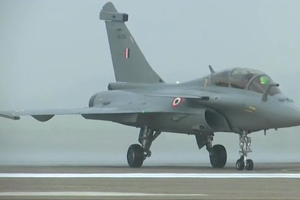

Falsified: False


In [55]:
item = val_df.iloc[16010]
text = item['full_text']  # original caption

img_filename = item['filename']
image_path = os.path.join(val_img_dir, img_filename)

raw_image = Image.open(image_path).convert('RGB')
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
# generate caption
generated_text = model.generate({"image": image, "prompt": "Question: Could you describe the image in detail? Answer:"}, repetition_penalty=5.0, length_penalty=2.0)
# ['a large fountain spewing water into the air']
print(f"Generated caption:\n{generated_text}")
print(f"Original text:\n{text}")
print("Input image:")
display(raw_image.resize((300, 200)))
print(f"Falsified: {item['falsified']}")